# <p style='color:blue;'> Hackathon - IA </p>
## <p style='color:magenta;'> Atividade Machine Learning #2 </p>

- - - 

Este Notebook tem o propósito de auxiliá-los na realização da segunda atividade de Machine Learning e nesta atividade, vocês vão desenvolver um classificador de *Fake News*.

Na pasta `./dataset_full` vocês poderão encontrar o dataset completo dividido entre as pastas <u style='color:red'>Fake</u> e <u style='color:green'>True</u> que contém respectivamente as amostras verdadeiras e falsas das notícias. Além destas pastas, podem ser encontradas também a pasta `information` que contém as seguintes informações sobre cada um dos arquivos: 

* Autor
* Link
* Categoria
* Data de publicação
* Número de Tokens
* Número de palavras sem pontuações
* Número de tipos
* Número de links dentro das notícias
* Número de palavras maiúsculas
* Número de verbos
* Número de verbos subjuntivos de imperativos
* Número de substantivos
* Número de adjetivos
* Número de advérbios
* Número de verbos modais
* Número de primeiro e segundo pronomes pessoais no singular
* Número de primeiros pronomes pessoais no plural
* Número de pronomes
* Pausalidade
* Número de caracteres 
* Tamanho médio da setença
* Tamanho médio da palavra
* Porcentagem de notícias com erros de 'fala'
* Emoção
* Diversidade

 - - -

# <p style='color:green;'> Critérios de avaliação </p>

Nesta atividade será avaliado o estudo dos dados, o processamento do texto e também a contrução dos modelos.

Vocês devem utilizar um, **ou mais**, modelos da preferência de vocês, desde que se limitem a modelos de MACHINE LEARNING e comparar seus resultados.

- A contrução e explicação de cada uma das decisões tomadas serão mais bem avaliadas do que métricas sobre determinado modelo.
- Todo o trabalho será avalidado (tanto resultados positivos quanto negativos).
- A organização será avaliada.
- Ninguém precisa ser o Deus do Pep8, mas aqueles que respeitarem os padrões também serão melhor avaliados.
- Se você estiver conectado à internet aparecerão gatinhos legais no seu Jupyter.
- Lembrem-se das aulas, mas vocês estão livres para utilizar a criatividade.

> Essa atividade pode ser entregue até o dia 22/02/2020 no e-mail saraselisn@gmail.com

# <p style='color:gray;'> Data Science </p>

![cat_science](https://miro.medium.com/max/500/1*ZhYNqU2y96_f3QkWq9oiWQ.jpeg)

In [0]:
# Imports mais globais de todo o Notebook

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import spacy
import spacy.cli

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
spacy.cli.download('pt')

# Variavel que indica se deve ser realizado todo o procedimento local para geração 
# de arquivos intermediários ou se apenas realiza o download dos arquivos em processamentos
# já realizados previamente (Valor como False é mais rápido!)

LOCAL = False


pt_stopwords = set(stopwords.words('portuguese'))

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [0]:
fake_info_link = 'https://drive.google.com/open?id=1-yiSxxTM54VqmRLRuXSy0NyOAQSUwNUN'

fluff, file_id = fake_info_link.split('=')

In [0]:
from os import listdir
import re
 
# Metodo que retorna a contagem de todas as entidades identicadas no documento indicado
def get_text_entities(file_path):
  text = open(file_path).read()
  text = ' '.join(word for word in text.split() if word not in pt_stopwords)

  nlp = spacy.load('pt')
  doc = nlp(text)

  doc_entity_counts = {}
  doc_ents = []
  for entity in doc.ents:
    doc_ents.append(entity.text)
    if entity.label_ != 'MISC':
      if entity.text in doc_entity_counts:
        doc_entity_counts[entity.text] += 1
      else:
        doc_entity_counts[entity.text] = 1

  return doc_entity_counts

# 
# def get_file_list(folder_id):
#   return drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()

# Obtenção em forma de um dataframe das informações contidas nos arquivos de Information
def get_info_data(columns, path):
  filelist_len = len(listdir(path))

  rows = []
  i = 0
  
  for filename in listdir(path):
    contents = np.asarray(open(path+filename, 'r').read().split('\n'))
    contents = np.append(contents, [filename.replace('-meta','')])
    rows.append(contents)

    i +=1
  return pd.DataFrame(rows, columns=columns)


In [0]:
# Obtenção do dataset em formato .zip e extraindo todo o conteúdo na pasta 'dataset'
import zipfile

fake_info_link = 'https://drive.google.com/open?id=1qlrvKbCnYfYn0t2HyangP4kjS2lWvhjX'

fluff, file_id = fake_info_link.split('=')
downloaded = drive.CreateFile({'id':file_id})
downloaded.GetContentFile('dataset.zip')

archives = zipfile.ZipFile('dataset.zip')

archives.extractall('dataset')

A seguir, é criado um dataset que contém os metadados dos textos conforme indicado no início desse documento. Isso é feito a partir do uso do método *get_info_data* para a obtenção de datasets para **fake news** e **true news**.

In [0]:
from time import sleep

columns=['Autor',
         'Link',
         'Categoria',
         'Data de publicação',
         'Número de Tokens',
         'Número de palavras sem pontuações',
         'Número de tipos',
         'Número de links dentro das notícias',
         'Número de palavras maiúsculas',
         'Número de verbos',
         'Número de verbos subjuntivos de imperativos',
         'Número de substantivos',
         'Número de adjetivos',
         'Número de advérbios',
         'Número de verbos modais',
         'Número de primeiro e segundo pronomes pessoais no singular',
         'Número de primeiros pronomes pessoais no plural',
         'Número de pronomes',
         'Pausalidade',
         'Número de caracteres',
         'Tamanho médio da setença',
         'Tamanho médio da palavra',
         'Porcentagem de notícias com erros de "fala"',
         'Emoção',
         'Diversidade',
         'filename',
          ]
print('getting files info...')

fake_info_df = get_info_data(columns, 'dataset/dataset_full_/Information/Fake/')
fake_info_df['label'] = 0

true_info_df = get_info_data(columns, 'dataset/dataset_full_/Information/True/')
true_info_df['label'] = 1

getting files info...


In [0]:
fake_info_df.sample(5)

,Autor,Link,Categoria,Data de publicação,Número de Tokens,Número de palavras sem pontuações,Número de tipos,Número de links dentro das notícias,Número de palavras maiúsculas,Número de verbos,Número de verbos subjuntivos de imperativos,Número de substantivos,Número de adjetivos,Número de advérbios,Número de verbos modais,Número de primeiro e segundo pronomes pessoais no singular,Número de primeiros pronomes pessoais no plural,Número de pronomes,Pausalidade,Número de caracteres,Tamanho médio da setença,Tamanho médio da palavra,"Porcentagem de notícias com erros de ""fala""",Emoção,Diversidade,filename,label
3028,None,https://www.diariodobrasil.org/americanos-inve...,tv_celebridades,02/12/2017,306,262,168,0,3,45,1,71,19,12,7,0,0,11,2.44444,1350,14.5556,5.15267,0.0152672,0.267241,0.641221,496.txt,0
2695,None,https://www.diariodobrasil.org/acusado-de-tent...,politica,26/05/2016,231,199,120,0,6,33,1,55,5,8,3,0,0,17,2.66667,901,16.5833,4.52764,0.0,0.147727,0.603015,2759.txt,0
117,None,https://www.diariodobrasil.org/proximo-alvo-de...,sociedade_cotidiano,07/04/2017,300,265,152,0,0,44,5,63,23,15,2,2,4,19,2.5,1254,18.9286,4.73208,0.0,0.35514,0.573585,1392.txt,0
2006,None,https://www.diariodobrasil.org/a-maior-vergonh...,tv_celebridades,01/11/2016,108,84,71,2,2,11,2,28,7,6,2,0,0,4,2.18182,436,7.63636,5.19048,0.0,0.333333,0.845238,1994.txt,0
2065,None,https://www.diariodobrasil.org/europa-acorda-s...,sociedade_cotidiano,22/03/2016,139,124,93,0,0,18,0,37,10,7,4,0,0,6,1.5,649,12.4,5.23387,0.0,0.309091,0.75,3038.txt,0


In [0]:
true_info_df.sample(5)

,Autor,Link,Categoria,Data de publicação,Número de Tokens,Número de palavras sem pontuações,Número de tipos,Número de links dentro das notícias,Número de palavras maiúsculas,Número de verbos,Número de verbos subjuntivos de imperativos,Número de substantivos,Número de adjetivos,Número de advérbios,Número de verbos modais,Número de primeiro e segundo pronomes pessoais no singular,Número de primeiros pronomes pessoais no plural,Número de pronomes,Pausalidade,Número de caracteres,Tamanho médio da setença,Tamanho médio da palavra,"Porcentagem de notícias com erros de ""fala""",Emoção,Diversidade,filename,label
2790,"Por Valeska Lippel, NSC TV",https://g1.globo.com/sc/santa-catarina/seu-din...,politica,27/03/2018 07h15,538,467,256,None,0,96,6,109,23,38,11,9,0,45,2.21875,2182,14.5938,4.67238,0.0,0.297561,0.54818,2441.txt,1
2834,Vitor Tavares e Breno Pires,http://politica.estadao.com.br/blogs/fausto-ma...,politica,17 de abril de 2017,678,571,284,None,0,70,2,174,16,19,10,3,0,31,3.96296,2744,21.1481,4.8056,0.0,0.143443,0.497373,1361.txt,1
1282,Por G1,https://g1.globo.com/agenda-do-dia/noticia/qua...,politica,24/01/2018 01h30,661,602,350,None,9,91,4,179,27,25,19,1,0,18,1.40476,2902,14.3333,4.8206,0.00166113,0.192593,0.581395,2957.txt,1
1629,Por G1 PR,https://g1.globo.com/pr/oeste-sudoeste/noticia...,tv_celebridades,27/03/2018 20h12,666,563,300,None,4,109,3,157,19,32,28,6,3,35,2.64103,2722,14.4359,4.83481,0.0,0.191729,0.53286,3476.txt,1
1733,Sonia Racy,http://cultura.estadao.com.br/blogs/direto-da-...,sociedade_cotidiano,19 de março de 2018,1602,1373,646,0,1,271,16,332,102,103,33,4,1,117,2.57303,6674,15.427,4.86089,0.002185,0.339967,0.470503,2023.txt,1


- - -

# <p style='color:purple;'> Text Processing <p>

![cat_texting](http://2.bp.blogspot.com/-lnsoTuz03Ik/T-3x6o6q1aI/AAAAAAAAAEw/lxxOy82Gp7o/s1600/cattypes.jpg)

Dada a possibilidade de extração de *tokens* de um texto, resolveu-se identificar os pesos das entidades de maior ocorrência em todos os textos. Para isso, primeiro, é necessario identificar quais são essas entidades, o que é realizado no bloco a seguir, a partir do método **get_text_entities** que retorna um dicionário que contém a quantidade de ocorrência das entidades identificas no texto indicado. 

In [0]:
from collections import Counter
import csv

# Caso deseja-se não usar o CSV resultante desse bloco já na nuvem, cria-se o arquivo True_False.csv
if(LOCAL):
  entities = {}

  for filename in listdir('dataset/dataset_full_/True/'):
    entities = dict(Counter(entities) + Counter(get_text_entities('dataset/dataset_full_/True/' + filename)))
  for filename in listdir('dataset/dataset_full_/Fake/'):
    entities = dict(Counter(entities) + Counter(get_text_entities('dataset/dataset_full_/Fake/' + filename)))

  with open('True_False.csv', 'w') as f:
      for key in entities.keys():
          f.write("%s;%s\n"%(key,entities[key]))
# Caso queira apenas obter o arquivo resultante guardado na nuvem (mais rápido!!)
else:
  entities_csv = 'https://drive.google.com/open?id=1tIoT4SJmYd8FMTxGMJyhbn6YSJXM1rPC'

  file_id = entities_csv.split('=')[1]
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile('True_False.csv')

O resultado disso foi guardado em um arquivo chamado **True_False.csv** para possibilitar tratamentos e análises dessas informações. Ele então é lido e colocado em um dicionário e, em seguida, é identificado as 10 entidades que tem a maior quantidade de ocorrências em todos os textos do dataset. Isso é feito nos dois blocos de código a seguir.

In [0]:
file_entities = {}
with open('True_False.csv', 'r') as f:
    for line in f:
      file_entities[line.strip().split(';')[0]] = int(line.strip().split(';')[1])
file_entities['RJ']

222

In [0]:
from operator import itemgetter 


most_used_entities = dict(sorted(file_entities.items(), key = itemgetter(1), reverse = True)[:10])
most_used_entities

{'Brasil': 5112,
 'EUA': 2015,
 'Justiça': 2118,
 'Lava Jato': 2687,
 'Lula': 8000,
 'Michel Temer': 1966,
 'Odebrecht': 2019,
 'PT': 2697,
 'STF': 2706,
 'Temer': 3035}

Acima, estão apresentados as entidades que mais ocorrem em todos os textos do datset.

Como mostrado, podem existir campos no dicionário repetidos devido ao campos em que uma entidade que são iguais (como 'Temer' e 'Michel Temer'). Portanto, propõe-se juntar essas entidades e seus somatórios de ocorrências.

In [0]:
# junção dos campos já presentes em most_used_entities
file_entities['Temer'] += file_entities['Michel Temer']


file_entities['EUA'] += file_entities['Estados Unidos']
file_entities['PT'] += file_entities['Partido Trabalhadores']
del file_entities['Michel Temer']
del file_entities['Estados Unidos']
del file_entities['Partido Trabalhadores']

In [0]:
possible_candidates = []
for key in file_entities:
  key_words = key.split()
  # print(key_words)
  for word in key_words:
    if word in most_used_entities:
      file_entities[word] += file_entities[key]

# possible_candidates
most_used_entities = dict(sorted(file_entities.items(), key = itemgetter(1), reverse = True)[:10])
most_used_entities

{'Brasil': 11390,
 'Dilma': 1953,
 'EUA': 6737,
 'Justiça': 6111,
 'Lava Jato': 2687,
 'Lula': 19449,
 'Odebrecht': 5190,
 'PT': 6135,
 'STF': 5713,
 'Temer': 10664}

Acima, estão apresentadas as entidades de maior ocorrência. A partir desses valores, verifica-se *frequency–inverse document frequency* em cada documento dessas palavras. Isso é feito nos quatro blocos de códigos a seguir.

In [0]:
# Como tf-idf é feito com palavras e temos um termo que contém duas palavras, 
# juntamos essa chave em uma palavra só para pesquisa nos documentos e tratamos 
# isso na leitura dos documentos em si

most_used_entities['LavaJato'] = most_used_entities['Lava Jato']
del most_used_entities['Lava Jato']

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Criação das colunas que apresentarão os valores de tf-idf das palavras mais usadas
for key in most_used_entities:
  # voc[key] = count
  # count += 1
  true_info_df[key + ' tfidf'] = 0
  fake_info_df[key + ' tfidf'] = 0

# Obtenção das listas de arquivos fake e true
true_file_list = listdir('dataset/dataset_full_/True/')
true_file_list = ['dataset/dataset_full_/True/' + item for item in true_file_list]
fake_file_list = listdir('dataset/dataset_full_/Fake/')
fake_file_list = ['dataset/dataset_full_/Fake/' + item for item in fake_file_list]

# Criação do vetorizador para ft-idf
vectorizer = TfidfVectorizer(stop_words=stopwords.words('portuguese'), lowercase=False)

In [0]:
import progressbar
from time import sleep

# Obtenção dos ft-idf das palavras de maior uso de cada documento verdadeiro
print('Getting tfidf from true articles...')
sleep(1)

# Barra de progresso de processamento dos textos
true_bar = progressbar.ProgressBar(maxval=len(true_file_list), \
  widgets=[progressbar.Bar('#', '[', ']'), '0/{}   '.format(len(true_file_list), progressbar.Percentage)])
true_bar.start()
i = 0

for filename in true_file_list:
  i += 1
  true_bar.widgets[1] = ' {}/{}\t\treading {}    '.format(i,len(true_file_list),filename.split('/')[-1].ljust(10))
  true_bar.update(i)
  
  # Cálculo do tf-idf para o texto do arquivo
  X = vectorizer.fit_transform([open(filename, 'r').read().replace('Lava Jato', 'LavaJato')])
  dense = X.todense()
  denselist = dense.tolist()
  feature_names = vectorizer.get_feature_names()
  df = pd.DataFrame(denselist, columns=feature_names)
  # Atualização dos valores de tf-idf para os campos do dataframe
  for key in most_used_entities:
    if key in df:
      true_info_df.loc[true_info_df.filename == filename.split('/')[-1], key + ' tfidf'] = df[key].values[0]

Getting tfidf from true articles...


[########################################## ] 3555/3600		reading 1302.txt      

In [0]:
# Obtenção dos ft-idf das palavras de maior uso de cada documento fake
print('Getting tfidf from fake articles...')
sleep(1)

# Barra de progresso de processamento dos textos
fake_bar = progressbar.ProgressBar(maxval=len(fake_file_list), \
  widgets=[progressbar.Bar('#', '[', ']'), '0/{}'.format(len(fake_file_list), progressbar.Percentage)])
fake_bar.start()
i = 0
for filename in fake_file_list:
  i += 1
  fake_bar.widgets[1] = ' {}/{}\t\treading {}    '.format(i,len(fake_file_list),filename.split('/')[-1].ljust(10))
  fake_bar.update(i)

  # Cálculo do tf-idf para o texto do arquivo
  X = vectorizer.fit_transform([open(filename, 'r').read().replace('Lava Jato', 'LavaJato')])
  dense = X.todense()
  denselist = dense.tolist()
  feature_names = vectorizer.get_feature_names()
  df = pd.DataFrame(denselist, columns=feature_names)
  # Atualização dos valores de tf-idf para os campos do dataframe
  for key in most_used_entities:
    if key in df:
      fake_info_df.loc[fake_info_df.filename == filename.split('/')[-1], key + ' tfidf'] = df[key].values[0]

Getting tfidf from fake articles...


[###########################################] 3601/3601		reading 3421.txt      

In [0]:
# Verificação de que todos os tf-idf foram calculados e armazenados
true_info_df.max()

Autor                                                                                               Zeina Latif
Link                                                          https://www1.folha.uol.com.br/poder/2018/03/na...
Categoria                                                                                       tv_celebridades
Data de publicação                                                                                     9/8/2017
Número de Tokens                                                                                            999
Número de palavras sem pontuações                                                                           999
Número de tipos                                                                                             999
Número de links dentro das notícias                                                                        None
Número de palavras maiúsculas                                                                           

In [0]:
# Junção dos dois dataframes em um só
full_df = pd.concat([fake_info_df, true_info_df])

full_df.sample(5)

,Autor,Link,Categoria,Data de publicação,Número de Tokens,Número de palavras sem pontuações,Número de tipos,Número de links dentro das notícias,Número de palavras maiúsculas,Número de verbos,Número de verbos subjuntivos de imperativos,Número de substantivos,Número de adjetivos,Número de advérbios,Número de verbos modais,Número de primeiro e segundo pronomes pessoais no singular,Número de primeiros pronomes pessoais no plural,Número de pronomes,Pausalidade,Número de caracteres,Tamanho médio da setença,Tamanho médio da palavra,"Porcentagem de notícias com erros de ""fala""",Emoção,Diversidade,filename,label,Lula tfidf,Brasil tfidf,Temer tfidf,EUA tfidf,PT tfidf,Justiça tfidf,STF tfidf,Odebrecht tfidf,Dilma tfidf,LavaJato tfidf
454,None,https://www.diariodobrasil.org/eduardo-cunha-g...,politica,17/12/2015,14,9,9,0,1,1,0,5,0,0,0,0,0,0,1.66667,48,3.0,5.33333,0.0,0.0,1.0,3386.txt,0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2977,None,https://www.diariodobrasil.org/enzzo-estuda-de...,tv_celebridades,22/01/2018,191,155,94,0,0,41,2,39,7,4,3,2,0,17,2.4,671,10.3333,4.32903,0.0,0.1375,0.606452,345.txt,0,0.138675,0.069338,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1383,"Julia Lindner, Igor Gadelha e Renan Truffi, O...","http://politica.estadao.com.br/noticias/geral,...",politica,17 de fevereiro de 2018,780,684,328,0,13,98,7,226,39,24,8,1,0,37,2.74286,3308,19.5429,4.83626,0.0,0.194444,0.479532,722.txt,1,0.381201,0.000000,0.0,0.0,0.322554,0.0,0.0,0.0,0.0,0.0
1861,None,https://www.diariodobrasil.org/contraste-enqua...,politica,30/11/2016,56,47,38,0,3,7,0,12,3,3,0,0,0,5,1.5,246,7.83333,5.23404,0.0,0.315789,0.808511,1888.txt,0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1953,Fábio Silveira,https://g1.globo.com/pr/norte-noroeste/noticia...,religiao,3/1/2018,118,100,67,None,3,20,0,28,0,3,4,0,0,4,2.0,470,11.1111,4.7,0.01,0.0625,0.67,187.txt,1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [0]:
# Retirada de valores que não serão utilizados
full_df.drop(['Link', 'Data de publicação', 'filename'], axis=1, inplace=True)

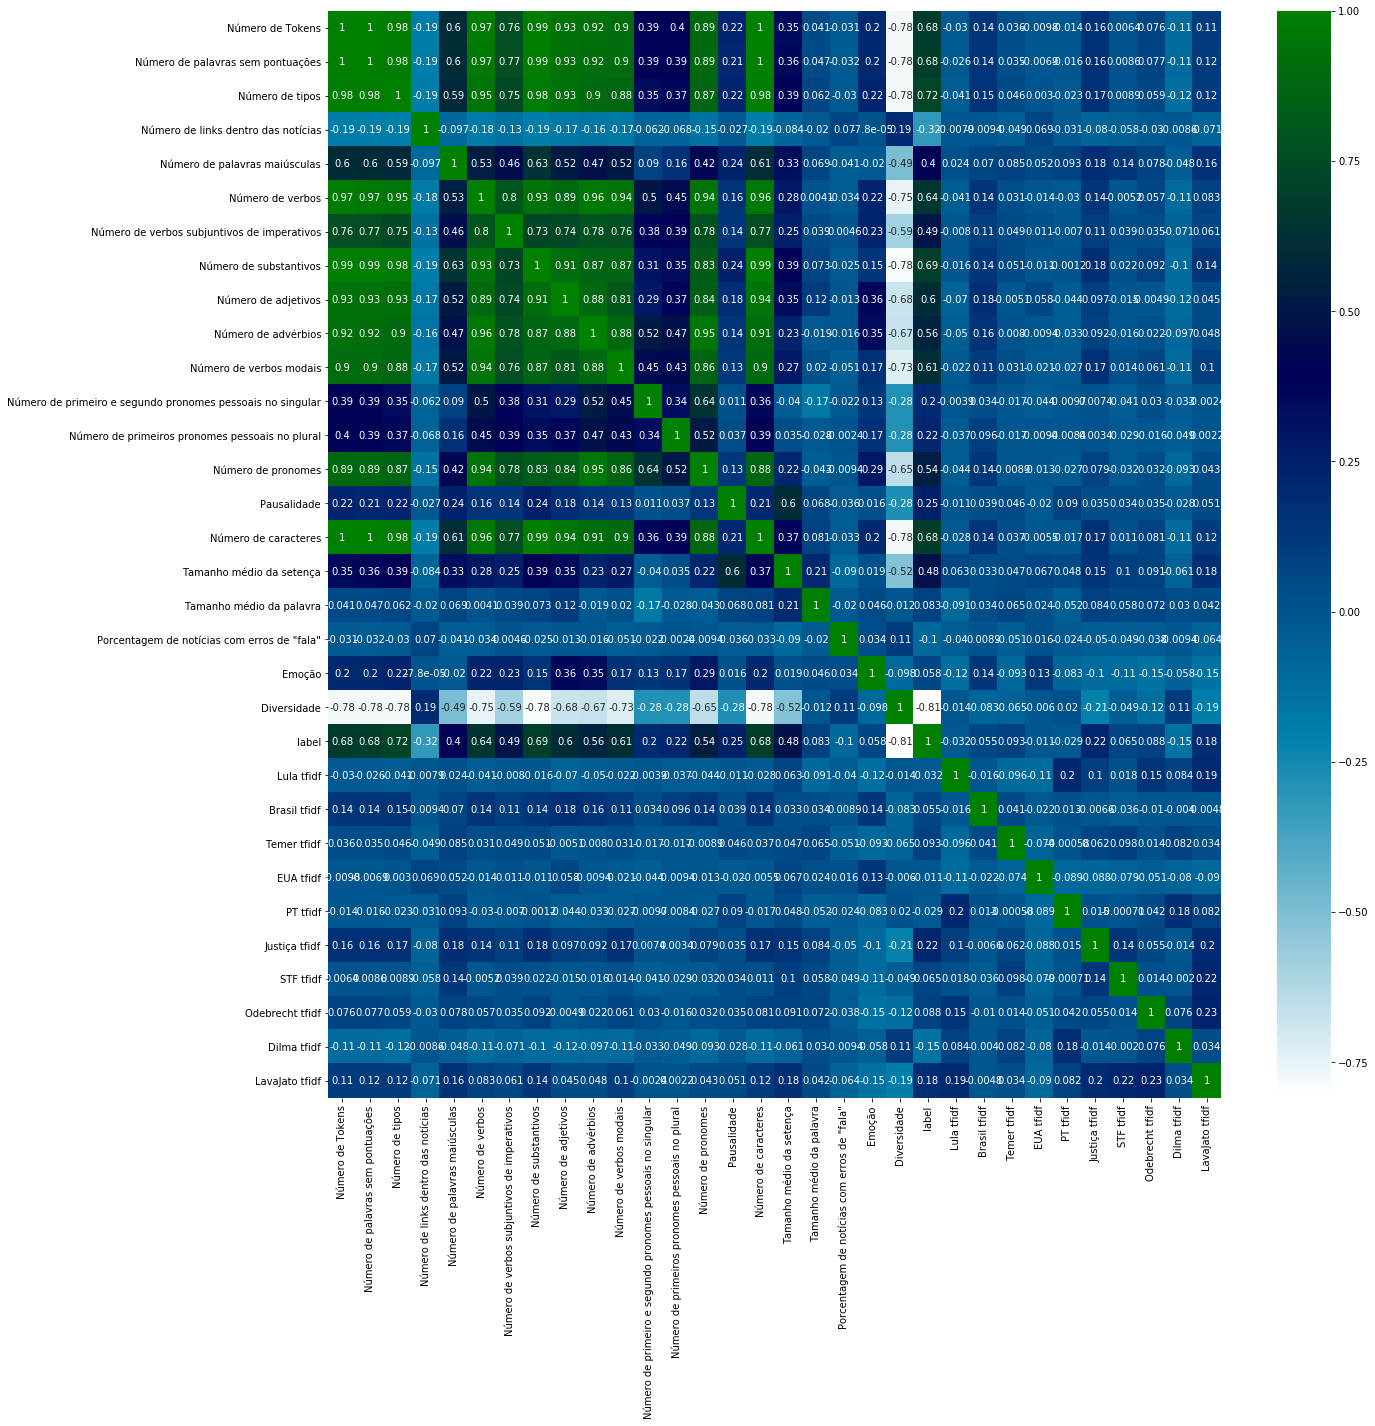

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Verificação da correlação entre os valores de todas as variaveis do dataset
plt.figure(figsize=(20, 20))
sns.heatmap(full_df.replace('None', 0).drop(['Autor', 'Categoria'], axis=1).astype(float).corr(), annot=True, cmap='ocean_r', cbar=True)
plt.show()

- - -

# <p style='color:brown;'> ML </p>

![machine_cat](https://pbs.twimg.com/media/DQJWAk5UEAEkR1b?format=jpg&name=360x360)

## Random Forest

Escolheu-se iniciar com o modelo de Random Forest. A seguir, apresenta-se a criação do dataframe para o modelo, a separação entre conjunto de treino e teste, o treino e sua validação.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [0]:
# Criação do dataframe para o modelo sem valores categoricos/não numéricos
random_forest_df = full_df.drop(['Autor', 'Categoria'], axis=1)

random_forest_df.sample(5)

,Número de Tokens,Número de palavras sem pontuações,Número de tipos,Número de links dentro das notícias,Número de palavras maiúsculas,Número de verbos,Número de verbos subjuntivos de imperativos,Número de substantivos,Número de adjetivos,Número de advérbios,Número de verbos modais,Número de primeiro e segundo pronomes pessoais no singular,Número de primeiros pronomes pessoais no plural,Número de pronomes,Pausalidade,Número de caracteres,Tamanho médio da setença,Tamanho médio da palavra,"Porcentagem de notícias com erros de ""fala""",Emoção,Diversidade,label,Lula tfidf,Brasil tfidf,Temer tfidf,EUA tfidf,PT tfidf,Justiça tfidf,STF tfidf,Odebrecht tfidf,Dilma tfidf,LavaJato tfidf
1539,1062,935,462,0,15,127,5,288,42,33,19,0,1,43,2.59184,4584,19.0816,4.90267,0.0,0.180723,0.494118,1,0.36028,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.051469
167,774,677,294,0,8,93,6,215,26,29,12,0,0,30,3.59259,3382,25.0741,4.99557,0.0,0.178571,0.434269,1,0.00000,0.0,0.0,0.000000,0.028444,0.0,0.113776,0.0,0.0,0.028444
3074,888,751,362,None,6,131,6,212,31,33,31,2,1,29,3.60526,3499,19.7632,4.65912,0.00133156,0.186589,0.482024,1,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
2104,841,750,369,0,7,91,2,232,42,35,9,0,0,26,2.21951,3598,18.2927,4.79733,0.00533333,0.23839,0.492,1,0.00000,0.0,0.0,0.032009,0.000000,0.0,0.000000,0.0,0.0,0.000000
36,216,189,135,0,6,36,5,50,11,12,10,0,0,12,1.58824,900,11.1176,4.7619,0.0,0.267442,0.714286,0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [0]:
# Separação dos conjuntos de treino e teste do modelo
X_train, x_test, Y_train, y_test = train_test_split(random_forest_df.drop(['label'], axis=1), random_forest_df['label'], test_size=0.3, random_state=42)

In [0]:
random_forest_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 0 to 3599
Data columns (total 32 columns):
Número de Tokens                                              7200 non-null object
Número de palavras sem pontuações                             7200 non-null object
Número de tipos                                               7200 non-null object
Número de links dentro das notícias                           7200 non-null object
Número de palavras maiúsculas                                 7200 non-null object
Número de verbos                                              7200 non-null object
Número de verbos subjuntivos de imperativos                   7200 non-null object
Número de substantivos                                        7200 non-null object
Número de adjetivos                                           7200 non-null object
Número de advérbios                                           7200 non-null object
Número de verbos modais                                       7

In [0]:
# sns.pairplot(random_forest_df[['LavaJato tfidf', 'Dilma tfidf', 'Lula tfidf', 'Brasil tfidf', 'Temer tfidf', 'EUA tfidf', 'Justiça tfidf', 'PT tfidf', 'STF tfidf', 'Odebrecht tfidf', 'label']], hue='label')

In [0]:
# Criação do modelo com todos os parâmetros default
random_forest_model = RandomForestClassifier(random_state=42)

In [0]:
# Treino do modelo a partir do conjunto de dados separado para treino e suas labels
X_train = X_train.replace('None', 0)
random_forest_model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
# Obtenção da predição a partir do conjunto de teste com o modelo criado
x_test = x_test.replace('None', 0)
y_pred = random_forest_model.predict(x_test)

In [0]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

# Verificação da accuracy, recall e precision do modelo a partir da predição com valores de teste
print('Model Accuracy:\t\t', accuracy_score(y_test, y_pred))
print('Model Recall:\t\t', recall_score(y_test, y_pred))
print('Model Precision:\t', precision_score(y_test, y_pred))

Model Accuracy:		 0.9638888888888889
Model Recall:		 0.9589934762348555
Model Precision:	 0.9680150517403575


Todos os valores apresentados sobre o modelo se mostram muito positivas, sendo o menor valor o *Recall*. A seguir é apresentado a matriz de confusão sobre a validação com o conjunto de teste.

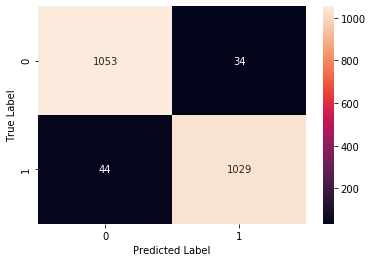

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

# Verificação da matriz de confusão a partir da predição com valores de teste
matrix = confusion_matrix(y_test.values, y_pred)


fig, ax = plt.subplots()

sns.heatmap(matrix, annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
fig.show()

## K Means

A seguir, utilizou-se o modelo não supervisionado *k_means* para verificar o seu comportamento com todos os dados existentes.

In [0]:
# Criação do dataframe para o modelo sem valores categoricos/não numéricos
k_means_df = full_df.drop(['Autor', 'Categoria'], axis=1)
k_means_df = k_means_df.replace('None', 0)
k_means_df.sample(5)

,Número de Tokens,Número de palavras sem pontuações,Número de tipos,Número de links dentro das notícias,Número de palavras maiúsculas,Número de verbos,Número de verbos subjuntivos de imperativos,Número de substantivos,Número de adjetivos,Número de advérbios,Número de verbos modais,Número de primeiro e segundo pronomes pessoais no singular,Número de primeiros pronomes pessoais no plural,Número de pronomes,Pausalidade,Número de caracteres,Tamanho médio da setença,Tamanho médio da palavra,"Porcentagem de notícias com erros de ""fala""",Emoção,Diversidade,label,Lula tfidf,Brasil tfidf,Temer tfidf,EUA tfidf,PT tfidf,Justiça tfidf,STF tfidf,Odebrecht tfidf,Dilma tfidf,LavaJato tfidf
2206,3227,2793,1111,0,25,401,10,758,168,160,56,2,2,147,4.42857,13268,28.5,4.75045,0.00179019,0.283003,0.39778,1,0.013443,0.053770,0.013443,0.026885,0.000000,0.000000,0.000000,0.000000,0.026885,0.000000
1036,2263,2022,856,0,16,309,13,553,107,90,52,10,2,136,2.93902,9745,24.6585,4.81949,0.0049456,0.228538,0.423343,1,0.205724,0.130915,0.130915,0.000000,0.018702,0.168320,0.074809,0.000000,0.018702,0.037404
2253,151,131,94,1,3,17,0,45,3,8,1,0,0,1,2.85714,634,18.7143,4.83969,0.0,0.177419,0.717557,0,0.438529,0.000000,0.350823,0.000000,0.000000,0.000000,0.175412,0.000000,0.000000,0.000000
254,1130,955,485,0,34,145,2,304,36,28,29,2,1,49,3.57143,4638,19.4898,4.85654,0.0,0.142539,0.507853,1,0.000000,0.000000,0.052396,0.000000,0.130991,0.104793,0.104793,0.026198,0.000000,0.261981
2777,1274,1140,458,0,17,160,12,339,54,56,14,3,0,74,2.48148,6140,21.1111,5.38596,0.000877193,0.220441,0.401754,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.078765,0.019691,0.393826,0.334752,0.078765


In [0]:
# Separação dos conjuntos de treino e teste do modelo
X_train, x_test, Y_train, y_test = train_test_split(k_means_df.drop(['label'], axis=1), k_means_df['label'], test_size=0.3, random_state=123)

In [0]:
from sklearn.cluster import KMeans

# Criação do modelo com apenas 2 clusters
k_means = KMeans(n_clusters=2, random_state=42)

In [0]:
# Treino do modelo a partir do
k_means.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [0]:
print(sum(Y_train.values == k_means.labels_)/len(Y_train))

# @@@@@ VERFICAR SE FAZ SENTIDO VISTO QUE É NÃO SUPERVISIONADO
# print('Model Accuracy:\t\t', accuracy_score(y_test, y_pred))
# print('Model Recall:\t\t', recall_score(y_test, y_pred))
# print('Model Precision:\t', precision_score(y_test, y_pred))

0.7251984126984127


In [0]:
y_pred = k_means.predict(x_test)

In [0]:
# Verificação da accuracy, recall e precision do modelo a partir da predição com valores de teste
print('Model Accuracy:\t\t', accuracy_score(y_test, y_pred))
print('Model Recall:\t\t', recall_score(y_test, y_pred))
print('Model Precision:\t', precision_score(y_test, y_pred))

Model Accuracy:		 0.7134259259259259
Model Recall:		 0.42657992565055763
Model Precision:	 0.9956616052060737


O valor de acurácia obtido não se mostra muito alto quando comparado com o resultado obtido em *Random Forest*, apesar dele também não ser muito baixo. Mas os resultados interessantes obtidos foram para Recall e Precision. Esses valores indicam que o modelo é extremamente eficaz em não errar noticias verdadeiras, apresentando uma *precision* de 99%. Portanto, ele é um modelo mais adequado para aplicações em que seja mais importante a veracidade das notícias do que a quantidade, mesmo levando em conta muitas classificações erradas sobre notícias verdadeiras como fake.

A matriz de confusão apresentada a seguir mostra que, para o conjunto de teste, apenas 2 das notícias falsas foi classificadas como verdadeiras.

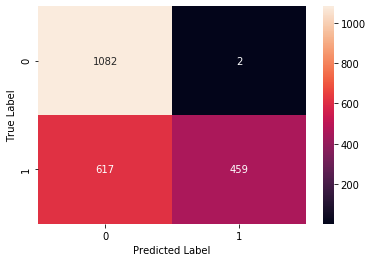

In [0]:
matrix = confusion_matrix(y_test.values, y_pred)

fig, ax = plt.subplots()

sns.heatmap(matrix, annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
fig.show()

## Naive Bayes

In [0]:
# Criação do dataframe para o modelo sem valores categóricos/não numéricos
gauss_nb_df = full_df.drop(['Autor', 'Categoria'], axis=1)
gauss_nb_df = gauss_nb_df.replace('None', 0)
gauss_nb_df.sample(5)

,Número de Tokens,Número de palavras sem pontuações,Número de tipos,Número de links dentro das notícias,Número de palavras maiúsculas,Número de verbos,Número de verbos subjuntivos de imperativos,Número de substantivos,Número de adjetivos,Número de advérbios,Número de verbos modais,Número de primeiro e segundo pronomes pessoais no singular,Número de primeiros pronomes pessoais no plural,Número de pronomes,Pausalidade,Número de caracteres,Tamanho médio da setença,Tamanho médio da palavra,"Porcentagem de notícias com erros de ""fala""",Emoção,Diversidade,label,Lula tfidf,Brasil tfidf,Temer tfidf,EUA tfidf,PT tfidf,Justiça tfidf,STF tfidf,Odebrecht tfidf,Dilma tfidf,LavaJato tfidf
1149,143,116,73,1,2,19,2,36,5,3,3,0,0,10,3.375,534,14.5,4.60345,0.0,0.145455,0.62931,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2607,732,651,319,0,10,91,9,185,30,27,22,0,0,24,2.7931,3124,22.4483,4.79877,0.0,0.206522,0.490015,1,0.379085,0.0,0.0,0.0,0.000000,0.068925,0.068925,0.0,0.0,0.034462
1857,216,191,130,0,2,42,0,50,10,10,12,1,0,7,2.27273,990,17.3636,5.18325,0.00515464,0.217391,0.680628,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
422,315,283,185,0,4,45,2,87,12,11,7,0,0,11,2.90909,1407,25.7273,4.97173,0.0106007,0.174242,0.65371,1,0.000000,0.0,0.0,0.0,0.129641,0.064820,0.000000,0.0,0.0,0.129641
830,1341,1188,588,0,16,181,9,311,81,53,26,1,0,109,3.64286,5990,28.2857,5.04209,0.0,0.272358,0.494949,1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [0]:
# Separação dos conjuntos de treino e teste do modelo
X_train, x_test, Y_train, y_test = train_test_split(gauss_nb_df.drop(['label'], axis=1), gauss_nb_df['label'], test_size=0.3, random_state=42)

In [0]:
from sklearn.naive_bayes import GaussianNB

# Criação do modelo com todos os parâmetros default
gnb = GaussianNB()

# Treino do modelo a partir do conjunto de dados separado para treino e suas labels
gnb.fit(X_train, Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
# Obtenção da predição a partir do conjunto de teste com o modelo criado
y_pred = gnb.predict(x_test)

In [0]:
# Verificação da accuracy, recall e precision do modelo a partir da predição com valores de teste
print('Model Accuracy:\t\t', accuracy_score(y_test, y_pred))
print('Model Recall:\t\t', recall_score(y_test, y_pred))
print('Model Precision:\t', precision_score(y_test, y_pred))

Model Accuracy:		 0.9310185185185185
Model Recall:		 0.8816402609506058
Model Precision:	 0.9772727272727273


Os valores apresentados foram bons, sendo a acurácia acima de 90%. Mas ainda se mostraram pior que os valores obtidos no *Random Forest*.

A seguir, é mostrado a matriz de confusão sobre o conjunto de teste deste modelo.

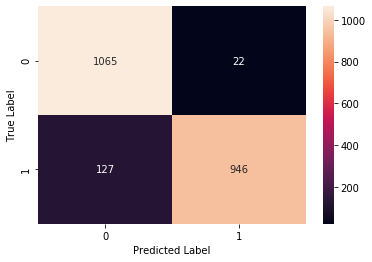

In [0]:
matrix = confusion_matrix(y_test.values, y_pred)

fig, ax = plt.subplots()

sns.heatmap(matrix, annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
fig.show()

## Decision Tree

In [0]:
# Criação do dataframe para o modelo sem valores categoricos/não numéricos
tree_df = full_df.drop(['Autor', 'Categoria'], axis=1)
tree_df = tree_df.replace('None', 0)
tree_df.sample(5)

,Número de Tokens,Número de palavras sem pontuações,Número de tipos,Número de links dentro das notícias,Número de palavras maiúsculas,Número de verbos,Número de verbos subjuntivos de imperativos,Número de substantivos,Número de adjetivos,Número de advérbios,Número de verbos modais,Número de primeiro e segundo pronomes pessoais no singular,Número de primeiros pronomes pessoais no plural,Número de pronomes,Pausalidade,Número de caracteres,Tamanho médio da setença,Tamanho médio da palavra,"Porcentagem de notícias com erros de ""fala""",Emoção,Diversidade,label,Lula tfidf,Brasil tfidf,Temer tfidf,EUA tfidf,PT tfidf,Justiça tfidf,STF tfidf,Odebrecht tfidf,Dilma tfidf,LavaJato tfidf
955,183,161,104,0,2,29,3,46,7,8,2,0,0,2,2.75,769,20.125,4.7764,0.00621118,0.2,0.645963,0,0.083624,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000
470,2528,2193,731,0,29,347,28,637,128,83,60,1,3,125,3.6413,11337,23.837,5.16963,0.0,0.214431,0.333333,1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.236303,0.0,0.0,0.00000
850,582,517,268,0,8,79,9,142,41,22,6,0,2,15,2.16667,2505,17.2333,4.84526,0.0,0.285068,0.518375,1,0.000000,0.000000,0.0,0.205557,0.0,0.000000,0.000000,0.0,0.0,0.00000
805,1164,1064,395,0,13,132,2,328,31,27,16,0,0,35,2.12766,5233,22.6383,4.91823,0.0,0.126087,0.371241,1,0.000000,0.000000,0.0,0.000000,0.0,0.020655,0.000000,0.0,0.0,0.04131
2487,113,104,79,0,3,23,1,26,6,5,6,0,1,4,0.818182,482,9.45455,4.63462,0.0,0.22449,0.759615,0,0.000000,0.117851,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000


In [0]:
# Separação dos conjuntos de treino e teste do modelo
X_train, x_test, Y_train, y_test = train_test_split(tree_df.drop(['label'], axis=1), tree_df['label'], test_size=0.3, random_state=42)

In [0]:
from sklearn import tree

# Criação do modelo com todos os parâmetros default
decision_tree = tree.DecisionTreeClassifier(random_state=42)

# Treino do modelo a partir do conjunto de dados separado para treino e suas labels
decision_tree.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [0]:
# Obtenção da predição a partir do conjunto de teste com o modelo criado
y_pred = decision_tree.predict(x_test)

In [0]:
# Verificação da accuracy, recall e precision do modelo a partir da predição com valores de teste
print('Model Accuracy:\t\t', accuracy_score(y_test, y_pred))
print('Model Recall:\t\t', recall_score(y_test, y_pred))
print('Model Precision:\t', precision_score(y_test, y_pred))

Model Accuracy:		 0.9384259259259259
Model Recall:		 0.9440820130475303
Model Precision:	 0.932780847145488


Os valores apresentados também foram bons, sendo a acurácia próximo de 95%, mas, novamente, se mostraram pior que os valores obtidos no *Random Forest*.

A seguir, é apresentada a matriz de confusão sobre o conjunto de teste do modelo criado.

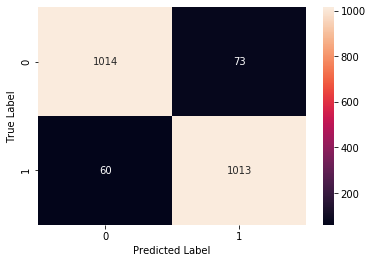

In [0]:
matrix = confusion_matrix(y_test.values, y_pred)

fig, ax = plt.subplots()

sns.heatmap(matrix, annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
fig.show()

## Logistic Regression

In [0]:
# Criação do dataframe para o modelo sem valores categóricos/não numéricos
logistic_reg_df = full_df.drop(['Autor', 'Categoria'], axis=1)
logistic_reg_df = logistic_reg_df.replace('None', 0)
logistic_reg_df.sample(5)

,Número de Tokens,Número de palavras sem pontuações,Número de tipos,Número de links dentro das notícias,Número de palavras maiúsculas,Número de verbos,Número de verbos subjuntivos de imperativos,Número de substantivos,Número de adjetivos,Número de advérbios,Número de verbos modais,Número de primeiro e segundo pronomes pessoais no singular,Número de primeiros pronomes pessoais no plural,Número de pronomes,Pausalidade,Número de caracteres,Tamanho médio da setença,Tamanho médio da palavra,"Porcentagem de notícias com erros de ""fala""",Emoção,Diversidade,label,Lula tfidf,Brasil tfidf,Temer tfidf,EUA tfidf,PT tfidf,Justiça tfidf,STF tfidf,Odebrecht tfidf,Dilma tfidf,LavaJato tfidf
3506,269,229,142,2,0,34,3,66,12,8,5,0,1,19,2.85714,1055,16.3571,4.60699,0.0,0.2,0.620087,0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
974,448,381,214,0,6,59,0,123,15,8,8,6,0,28,3.35,1867,19.05,4.90026,0.0,0.126374,0.56168,1,0.0,0.000000,0.089712,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2616,1060,896,440,0,6,155,1,251,30,39,34,0,0,41,2.98182,4207,16.2909,4.69531,0.00111607,0.169951,0.491071,1,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2908,1070,928,439,0,1,166,7,245,48,52,31,2,0,54,3.64103,4560,23.7949,4.91379,0.0075431,0.243309,0.47306,1,0.0,0.027369,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
664,1302,1150,611,0,4,204,10,300,70,65,29,0,0,84,2.08219,5719,15.7534,4.97304,0.00695652,0.267857,0.531304,1,0.0,0.000000,0.000000,0.05733,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Separação dos conjuntos de treino e teste do modelo
X_train, x_test, Y_train, y_test = train_test_split(tree_df.drop(['label'], axis=1), tree_df['label'], test_size=0.3, random_state=42)

In [0]:
from sklearn.linear_model import LogisticRegression

# Criação do modelo com todos os parâmetros default
logistic_reg_clf = LogisticRegression(random_state=42)

# Treino do modelo a partir do conjunto de dados separado para treino e suas labels
logistic_reg_clf.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Obtenção da predição a partir do conjunto de teste com o modelo criado
y_pred = logistic_reg_clf.predict(x_test)

In [0]:
print('Model Accuracy:\t\t', accuracy_score(y_test, y_pred))
print('Model Recall:\t\t', recall_score(y_test, y_pred))
print('Model Precision:\t', precision_score(y_test, y_pred))

Model Accuracy:		 0.950462962962963
Model Recall:		 0.9375582479030755
Model Precision:	 0.9617590822179732


Os valores apresentados foram todos acima de 90%. O resultado desse modelo foi o que mais chegou perto dos obtidos no *Random Forest*, sendo, portanto, o segundo melhor modelo em termos gerais dos testados!

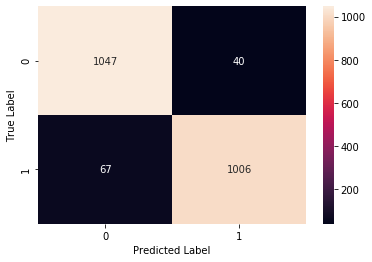

In [0]:
matrix = confusion_matrix(y_test.values, y_pred)

fig, ax = plt.subplots()

sns.heatmap(matrix, annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
fig.show()

# Flw
![cat_bye](https://twistedsifter.files.wordpress.com/2014/12/dog-waving-bye.jpg)